# Jane Street Puzzle - April 2024 - Robot Capture-the-Flag

## Problem Statement

It’s been a while and change, but the Robot Games are back once again. This time it’s Capture the Flag!

Two robots, Aaron and Erin, have made it to this year’s final! Initially they are situated at the center of a unit circle. A flag is placed somewhere inside the circle, at a location chosen uniformly at random. Once the flag is placed, Aaron is able to deduce its distance to the flag, and Erin is only able to deduce its direction to the flag. (Equivalently: if $(r, \theta)$ are the polar coordinates of the flag’s location, Aaron is told $r$ and Erin is told $\theta$.)

Both robots are allowed to make a single move after the flag is placed, if they wish. Any move they make is without knowledge of what the other robot is doing. (And they may not move outside the circle.)
Whichever robot is closer to the flag after these moves captures the flag and is declared the winner!

During the preliminaries it was discovered that Erin is programmed to play a fixed distance along the detected angle θ. Assuming otherwise optimal play by both robots, can you determine the probability that Aaron will win? (Please express your answer to 10 decimal places.)

## Solution

First let's import some libraries and create a plot that is useful to visualise the game. The plot is here for reference and will be explained later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, simplify, diff, integrate, solve, sqrt, acos, asin, pi
from scipy.optimize import minimize
from scipy.integrate import quad

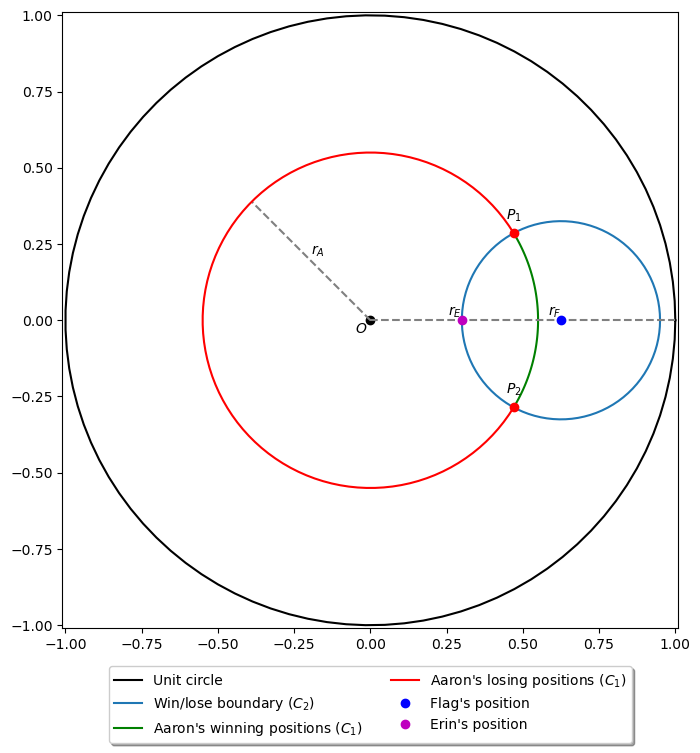

In [2]:
def find_circle_intersections(r0, r1, d):
    if d > r0 + r1 or d < abs(r0 - r1):  # No intersection
        return []
    a = (r0**2 - r1**2 + d**2) / (2 * d)
    h = np.sqrt(r0**2 - a**2)
    x2 = a / d * r_f
    y2 = h / d * r_f
    p1 = (x2, y2)
    p2 = (x2, -y2)
    return [p1, p2]

def cart_to_polar(x, y):
    return np.arctan2(y, x)

def plot_game(r_f, r_a, r_e):
    # Radius of decision boundary and
    radius_circle2 = abs(r_e - r_f)
    intersection_points = find_circle_intersections(r_a, radius_circle2, r_f)
    theta = np.linspace(0, 2 * np.pi, 100)

    # Circle 0 (Unit Circle)
    x_circle0 = np.cos(theta)
    y_circle0 = np.sin(theta)
    # Circle 2 (Win/lose boundary)
    x_circle2 = r_f + radius_circle2 * np.cos(theta)
    y_circle2 = radius_circle2 * np.sin(theta)

    # Create a dashed line showing the Aaron's radius
    angle_rad = np.radians(135)
    line_end_x = r_a * np.cos(angle_rad)
    line_end_y = r_a * np.sin(angle_rad)

    # Segments to plot
    if intersection_points:
        angles = [cart_to_polar(x, y) for x, y in intersection_points]
        angles.sort()
        theta_inside = np.linspace(*angles, 100)
        x_inside = r_a * np.cos(theta_inside)
        y_inside = r_a * np.sin(theta_inside)
        theta_outside = np.linspace(angles[1], angles[0] + 2 * np.pi, 100)
        x_outside = r_a * np.cos(theta_outside)
        y_outside = r_a * np.sin(theta_outside)

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(x_circle0, y_circle0, 'k-', label='Unit circle')
    ax.plot(x_circle2, y_circle2, label=r"Win/lose boundary ($C_2$)")
    ax.plot([0, line_end_x], [0, line_end_y], color='gray', linestyle='--', label='')
    if intersection_points:
        ax.plot(x_inside, y_inside, 'g-', label=r"Aaron's winning positions ($C_1$)")
        ax.plot(x_outside, y_outside, 'r-', label=r"Aaron's losing positions ($C_1$)")
        for point, label in zip(intersection_points, [r'$P_1$', r'$P_2$']):
            ax.plot(point[0], point[1], 'ro')  # Plotting the intersection points
            ax.annotate(label, point, textcoords="offset points", xytext=(0,10), ha='center')
    ax.hlines(0, 0, 1, colors='gray', linestyles='dashed')
    ax.plot([r_f], [0], 'bo', label="Flag's position")  # Circle 2 Center
    ax.plot([r_e], [0], 'mo', label="Erin's position")  # Erin's position on the x-axis
    ax.scatter([0], [0], color='k')  # Circle 1 Center
    ax.text(r_f, 0, r'$r_F$', verticalalignment='bottom', horizontalalignment='right')
    ax.text(r_e, 0, r'$r_E$', verticalalignment='bottom', horizontalalignment='right')
    ax.text(-0.05, -0.005, r'$O$', verticalalignment='top', horizontalalignment='left')
    ax.text(-0.15, 0.2, r'$r_A$', verticalalignment='bottom', horizontalalignment='right')
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.01)
    ax.set_aspect('equal', 'box')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    ax.set_aspect('equal', 'box')

r_a = 0.55
r_f = 0.625
r_e = 0.3

plot_game(r_f, r_a, r_e)

## Problem Set Up

In the following, the final position of Aaron, Erin and the flag (in polar coordinates) are given by $(r_A, \theta_A)$, $(r_E, \theta_E)$ and $(r_F, \theta_F)$, respectively and $O$ denotes the origin (i.e., the starting point of Aaron and Erin). Also, without loss of generality, we will assume that $\theta_E = \theta_F = 0$. Because Erin always moves in the direction of the flag, her final position is on a straight line that passes through the flag and the origin. We can simply rotate the circle (and all the points on it) such that this line is on the positive part of the x-axis. The visualisation above assumes such a rotation has been performed.

It was discovered during the preliminaries that Erin will always move a fixed distance $r_E$ along the angle $\theta_F$. As both players are rational (and pretty good at maths!), they will both determine the optimal $r_E$. This means that Aaron knows both $r_E$ and $r_F$ and can determine Erin's distance to the flag. Aaron does not know the direction of the flag and cannot do better than selecting $\theta_A$ randomly. His goal is therefore to pick $r_A$ such that it maximizes his probability of winning.

His location will be chosen uniformly at random on the circumference of a circle $C_1$ of radius $r_A$ centred at the origin. Erin's distance to the flag, $D = |r_E - r_F|$, determines the radius of circle $C_2$ centered at the flag's position $r_F$. Aaron captures the flag if he ends within $C_2$. The figure above shows a scenario where $r_E = 0.3$, $r_A = 0.55$, and $r_F = 0.625$. Here, $C_2$ acts as the decision boundary, with the green segment of $C_1$ (inside $C_2$) indicating Aaron's winning positions, and the red segment (outside $C_2$) showing losing positions. Aaron aims to maximize the proportion $\lambda$ of the green arc's length $L$ to the circumference of his circle $C_1$, where

\begin{equation}
    \lambda = \frac{L}{2\pi r_A} = \frac{\alpha r_A}{2\pi r_A} = \frac{\alpha}{2\pi},
\end{equation}

with $\alpha$ being the angle subtended by the intersections of $C_1$ and $C_2$. The problem, therefore, narrows down to maximizing $\alpha$.


## Numerical Solution

### Determining Aaron's Strategy


Let $P_1$ and $P_2$ be the intersection points between $C_1$ and $C_2$. To determine the angle $\alpha$ which we seek to maximize, note that the intersection points $P_1$ and $P_2$ are symmetric about the x-axis, giving

\begin{equation}
    \alpha = \angle P_1OP_2 = 2 \angle P_1Or_F = 2 \angle P_2Or_F.
\end{equation}

This leads directly to the use of the law of cosines within the triangle $\triangle P_1Or_F$, with known side lengths $r_A$, $r_F$, and $D$ (the distance between $P_1$ and $r_F$). We obtain

\begin{equation}
    \cos \left(\frac{\alpha}{2} \right) = \frac{r_A^2 + r_F^2 - D^2}{2 r_A r_F},
\end{equation}

yielding

\begin{equation}
    \alpha = 2 \arccos \left( \frac{r_A^2 + r_F^2 - D^2}{2 r_A r_F} \right).
\end{equation}

Differentiating $\alpha$ with respect to $r_A$ to find the maximum gives

\begin{equation}
    \frac{d \alpha}{d r_A} = 2 \frac{-r_A^2 - D^2 + r_F^2}{r_A \sqrt{4 r_A^2 r_F^2 - (r_A^2 - D^2 + r_F^2)^2}}.
\end{equation}

In [3]:
r_f, d, r_a = symbols('r_f D r_A', real=True, positive=True)
alpha = 2 * acos((r_a**2 - d**2 + r_f**2) / (2 * r_a * r_f))
dalpha = diff(alpha, r_a)
simplify(dalpha)

2*(-D**2 - r_A**2 + r_f**2)/(r_A*sqrt(4*r_A**2*r_f**2 - (-D**2 + r_A**2 + r_f**2)**2))

Setting it equal to zero and solving for $r_A$, we obtain the optimal radius

\begin{equation}
    r_A^* = \sqrt{-D^2 + r_F^2}
\end{equation}

In [4]:
solution = solve(dalpha, r_a)
solution = [simplify(sol) for sol in solution]
solution[0]

sqrt(-D**2 + r_f**2)

and the corresponding maximal proportion
\begin{equation}
    \lambda^* = \frac{\arccos \left( \frac{\sqrt{-D^2 + r_F^2}}{r_F} \right)}{\pi}.
\end{equation}

This looks good, however, it is not completely accurate. Here we assume that the two circles necessarily intersect. If they do not intersect, the function above is not defined. There are some scenarios where Aaron must pick $r_A$ such that $C_1$ and $C_2$ do not intersect. This happens whenever $r_F < \frac{1}{2} r_E$. In this case, Aaron can simply chose not to move and be guaranteed to win. In this case, $C_1$ is entirely contained within $C_2$. Therefore, we have

\begin{equation}
    \lambda^* = \begin{cases}
        1 & \text{if} \quad r_F < \frac{1}{2} r_E, \\
        \frac{1}{\pi} \arccos \left( \frac{\sqrt{r_F^2 - D^2}}{r_F} \right) & \text{otherwise}.
    \end{cases}
\end{equation}


### Determining Erin's Strategy

We now have figured out Aaron's optimial strategy. Given Erin's strategy and the distance between the flag and the center, Aaron moves a distance $r_A^*$ in a randomly chosen direction and his probability of winning is $\lambda^*$. We now need to figure out Erin's strategy. Erin's probability of winning is $1 - \lambda^*$. Her goal is therefore to minimize $\lambda^*$. As Erin is not aware of the distance between the flag and the origin, she must consider all the potential values for $r_F$ and their likelihood. She needs the probability density function of $r_F$.

To derive the probability density function (PDF) of the flag's distance $r_F$ from the center, we first calculate its cumulative distribution function (CDF). For any circle of radius $R$, if a point is picked uniformly at random, the probability that this point lies within a smaller circle of radius $x$ is the ratio of their areas. The CDF is given by
\begin{equation}
    F_X(x) = \frac{\pi x^2}{\pi R^2} = \frac{x^2}{R^2}.
\end{equation}
Differentiating this CDF gives us the PDF
\begin{equation}
    f_X(x) = \frac{d}{dx} \left( \frac{x^2}{R^2} \right) = \frac{2x}{R^2}.
\end{equation}

In our game setup, $R = 1$, thus the PDF for $r_F$ becomes $2r_F$. This PDF implies that the flag is more likely to be located near the perimeter of the circle. Erin, who is only aware of the direction to the flag but not its distance, must consider this PDF when planning her move. 

For a given value of $r_E$, we can figure out the probability that Aaron wins (this time $r_F$ is not known and we consider all the possibilities) by integrating $\lambda^*$ times the PDF of $r_F$ with respect to $r_F$ between 0 and 1. We will split the integral into three parts. The first one accounts for the cases where Aaron is guaranteed to win. The second and third parts are used to get rid of the absolute value computation for $D$. Let $P_A$ be the probability that Aaron wins, we have

\begin{equation}
    p_A = 2 \int_0^1 r_F \lambda^* dr_F = 2 \int_0^{\frac{1}{2}r_E} r_F dr_F + \frac{2}{\pi} \int_{\frac{1}{2}r_E}^{r_E} r_F \arccos \left( \frac{\sqrt{-(r_E - r_F)^2 + r_F^2}}{r_F} \right) dr_F + \frac{2}{\pi} \int_{r_E}^{1} r_F \arccos \left( \frac{\sqrt{-(r_F - r_E)^2 + r_F^2}}{r_F} \right) dr_F.
\end{equation}

The above integral gives the probability that Aaron wins given $r_E$. Therefore, Erin's strategy is to find $r_E$ such that the above expression is minimised.

First, let's try to integrate analytically.


In [5]:
x1, x2 = symbols('r_F r_E', real=True, positive=True)

integrand1 = integrate(2 * x1, (x1, 0, x2 / 2))
integrand2 = 2 * x1 * acos(sqrt(-(x2 - x1)**2 + x1**2) / x1) / pi
integrand3 = 2 * x1 * acos(sqrt(-(x1 - x2)**2 + x1**2) / x1) / pi

integral1 = integrate(integrand1, (x1, 0, x2 / 2))
integral2 = integrate(integrand2, (x1, x2 / 2, x2))
integral3 = integrate(integrand3, (x1, x2, 1))

simplify(integral1 + integral2 + integral3)

(pi*r_E**3 + 16*Integral(r_F*acos(sqrt(r_E)*sqrt(-r_E + 2*r_F)/r_F), (r_F, r_E/2, r_E)) + 16*Integral(r_F*acos(sqrt(r_E)*sqrt(-r_E + 2*r_F)/r_F), (r_F, r_E, 1)))/(8*pi)

Unfortunately, we cannot get a closed-form solution for this integral. We will proceed with numerical integration and minimisation.

In [6]:
def prob_aaron_wins_given_erin(x2_value):
    def integrand1(x1):
        return 2 * x1

    def integrand2(x1, x2):
        return 2 * x1 * np.arccos(np.sqrt(-((x2 - x1)**2) + x1**2) / x1) / np.pi

    def integrand3(x1, x2):
        return 2 * x1 * np.arccos(np.sqrt(-((x1 - x2)**2) + x1**2) / x1) / np.pi

    integral1, _ = quad(integrand1, 0, x2_value / 2, epsabs=1e-14, epsrel=1e-14)
    integral2, _ = quad(integrand2, x2_value / 2, x2_value, args=(x2_value,), epsabs=1e-14, epsrel=1e-14)
    integral3, _ = quad(integrand3, x2_value, 1, args=(x2_value,), epsabs=1e-14, epsrel=1e-14)

    return integral1 + integral2 + integral3


def objective_function(x2):
    return prob_aaron_wins_given_erin(x2[0])

x2_initial_guess = [0.5]
bounds = [(0, 1)]

# Optimization with high precision settings
result = minimize(objective_function, x2_initial_guess, method='L-BFGS-B', bounds=bounds,
                    options={'eps': 1e-11, 'ftol': 1e-11, 'gtol': 1e-11})

# Print the result
if result.success:
    print("Optimization succeeded.")
    print(f"Erin's optimal distance from the origin is: {result.x[0]:.10f}")
    print(f"Aaron's probability of winning is: {result.fun:.10f}")
else:
    print("Optimization failed.")
    print("Message:", result.message)

Optimization succeeded.
Erin's optimal distance from the origin is: 0.5013063820
Aaron's probability of winning is: 0.1661864865


## Closed-form Solution

The numerical method gives the correct result to 10 decimal places. However, there is a simpler method that gives a closed-form solution. 

In the method above, we found an expression for the angle $\alpha$ and maximised it using calculus. This led to a complex expression involving a square root within an inverse trigonometric function which we could not integrate analytically. We can actually avoid using calculus and get an expression that is much simpler. The key is to realise that when $\alpha$ is maximised, the line that passes through the origin and $P_1$ (or $P_2$) is tangent to $C_2$. By definition, this tangent line is perpendicular to the line going through $P_1$ and the center of $C_2$ which is $r_F$. Therefore, $\triangle OP_1r_F$ is a right triangle. We have an expression for the length of the three sides of the triangle so we can use a trigonometric function to determine (half of) the angle $\alpha$. The length of the hypothenuse is $r_F$, the length of the opposite side is $D$ and the length of the adjacent side is given by $\sqrt{-D^2 + r_F^2}$. Note that we retrieve our original function for $\alpha$ if we use a cosine function. However, in order to simplify the integration, it is preferable to use a simpler expression. In this case, we want avoid using the adjacent side to get rid of the square root. Therefore, we can determine $\alpha$ using the sine function which uses the opposite side and hypothenuse. Our optimal $\alpha$ is given by

\begin{equation}
    \alpha = 2 \arcsin \left( \frac{D}{r_F} \right)
\end{equation}

and the corresponding maximal proportion is

\begin{equation}
    \lambda^* = \begin{cases}
        1 & \text{if} \quad r_F < \frac{1}{2} r_E, \\
        \frac{1}{\pi} \arcsin \left( \frac{D}{r_F} \right) & \text{otherwise}.
    \end{cases}
\end{equation}

We now use the same method as before to obtain an expression for the probability that Aaron wins (given Erin's move). It is given by

\begin{equation}
    p_A = 2 \int_0^1 r_F \lambda^* dr_F = 2 \int_0^{\frac{1}{2}r_E} r_F dr_F + \frac{2}{\pi} \int_{\frac{1}{2}r_E}^{r_E} r_F \arcsin \left( \frac{r_E - r_F}{r_F} \right) dr_F + \frac{2}{\pi} \int_{r_E}^{1} r_F \arcsin \left( \frac{r_F - r_E}{r_F} \right) dr_F.
\end{equation}

In [7]:
x1, x2 = symbols('r_F r_E', real=True, positive=True)

integrand1 = 2 * x1
integrand2 = 2 * x1 * asin((x2 - x1) / x1) / pi
integrand3 = 2 * x1 * asin((x1 - x2) / x1) / pi

integral1 = integrate(integrand1, (x1, 0, x2 / 2))
integral2 = integrate(integrand2, (x1, x2 / 2, x2))
integral3 = integrate(integrand3, (x1, x2, 1))

res = integral1 + integral2 + integral3
res = res.simplify()

res

(-8*r_E**(5/2)*sqrt(2 - r_E) + 8*r_E**(3/2)*sqrt(2 - r_E) + 16*sqrt(r_E)*sqrt(2 - r_E) + 3*pi*r_E**3 + 32*r_E**3 - 64*r_E**2 - 6*pi*r_E**2 - 24*r_E*asin(r_E - 1) + 48*asin(r_E - 1))/(24*pi*(r_E - 2))

We now have a closed-form solution for the probability that Aaron wins given Erin's strategy. We need to find the minimum of this function so we first differentiate with respect to $r_E$.

In [8]:
derivative = diff(res, x2).simplify()
derivative

(3*pi*r_E**(11/2) + 32*r_E**(11/2) - 256*r_E**(9/2) - 24*pi*r_E**(9/2) + 72*pi*r_E**(7/2) + 768*r_E**(7/2) - 1024*r_E**(5/2) - 96*pi*r_E**(5/2) + 48*pi*r_E**(3/2) + 512*r_E**(3/2) - 8*r_E**5*sqrt(2 - r_E) + 56*r_E**4*sqrt(2 - r_E) - 128*r_E**3*sqrt(2 - r_E) + 64*r_E**2*sqrt(2 - r_E) + 128*r_E*sqrt(2 - r_E) - 128*sqrt(2 - r_E))/(12*pi*sqrt(r_E)*(r_E**4 - 8*r_E**3 + 24*r_E**2 - 32*r_E + 16))

We solve for the minimum of the function by setting the derivative equal to zero and solving the equation.

In [9]:
sols = solve(derivative, x2)
sols[0].simplify()

4*(4*(9*pi**2 + 192*pi + 1088)**(4/3) + (sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(2/3))/((sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(1/3)*(9*pi**2 + 192*pi + 1088)**(7/6))

This solution gives the optimal value of $r_E$.

In [10]:
sols[0].evalf()

0.501306994212753

Finally, we can work out the probability that Aaron wins given both players play optimally. 

In [11]:
res.subs(x2, sols[0]).simplify()

((sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**2*(9*pi**2 + 192*pi + 1088)**7*asin((-(sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(1/3)*(9*pi**2 + 192*pi + 1088)**(7/6) + 16*(9*pi**2 + 192*pi + 1088)**(4/3) + 4*(sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(2/3))/((sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(1/3)*(9*pi**2 + 192*pi + 1088)**(7/6))) + (sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(4/3)*(9*pi**2 + 192*pi + 1088)**(14/3)*(-64*(4*(9*pi**2 + 192*pi + 1088)**(4/3) + (sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(2/3))**2 - 6*pi*(4*(9*pi**2 + 192*pi + 1088)**(4/3) + (sqrt(9*pi**2 + 192*pi + 1024)*(9*pi**2 + 192*pi + 1088)**2 + (9*pi**2 + 192*pi + 1088)**(5/2))**(2/3))**2 + 

In [12]:
print(f'The probability that Aaron wins is {res.subs(x2, sols[0]).evalf(10)}.')

The probability that Aaron wins is 0.1661864865.
